## Waste Classification
```
Dataset Link:
https://www.kaggle.com/datasets/techsash/waste-classification-data?resource=download
```

In [1]:
# import neccessary libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import cv2
from tqdm import tqdm
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from glob import glob

## Create path for train and test images

In [2]:
# Train and test image directories
train_path = "../DATASET/TRAIN/"
test_path = "../DATASET/TEST/"

In [3]:
def load_images_and_labels(base_path):
    images = []
    labels = []

    # Categories of organic or recyclable
    categories = ['O', 'R']
    for category in categories:
        path = os.path.join(base_path, category)
        files = glob(os.path.join(path, "*"))
        
        count = 0
        for file in tqdm(files, desc=f"Loading {category} images"):
            img_array = cv2.imread(file)
            if img_array is not None:
                images.append(img_array)
                labels.append(category)
                count += 1
        
        print(f"Loaded {count} images for category '{category}'")
    
    data=pd.DataFrame({'image': images,'label': labels})
    return data

In [4]:
# Invoke function to create train_data_df
train_data_df = load_images_and_labels(train_path)

Loading O images: 100%|██████████████████████████████████████████████████████████| 12565/12565 [02:53<00:00, 72.44it/s]


Loaded 12565 images for category 'O'


Loading R images: 100%|████████████████████████████████████████████████████████████| 9999/9999 [02:30<00:00, 66.45it/s]

Loaded 9999 images for category 'R'


In [5]:
# Look into train_data_df information
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB


In [6]:
# Invoke function to create test_data_df
test_data_df = load_images_and_labels(test_path)

Loading O images: 100%|████████████████████████████████████████████████████████████| 1401/1401 [00:20<00:00, 68.14it/s]


Loaded 1401 images for category 'O'


Loading R images: 100%|████████████████████████████████████████████████████████████| 1112/1112 [00:27<00:00, 40.62it/s]

Loaded 1112 images for category 'R'


In [7]:
# Look into test_data_df information
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   2513 non-null   object
 1   label   2513 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


In [8]:
# View the shape of train and test dataset
print(f"Train dataset shape: {train_data_df.shape}")
print(f"Test dataset shape: {test_data_df.shape}")

Train dataset shape: (22564, 2)
Test dataset shape: (2513, 2)


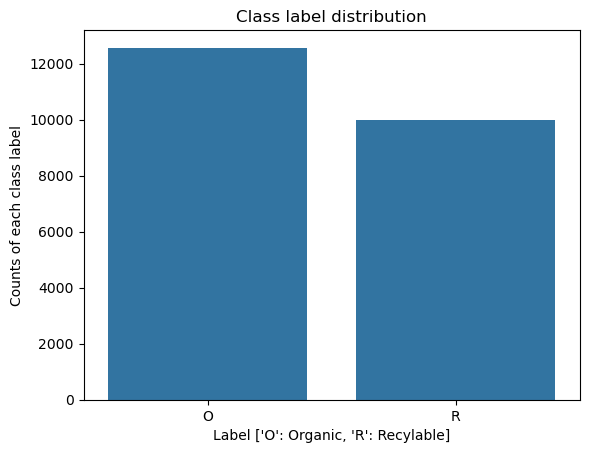

In [9]:
# Visualise the barplot (count) of each class label
train_label_distribution = train_data_df["label"].value_counts()

# A quick bar plot to see the distribution
label_class_plot = sns.barplot(x=train_label_distribution.index, y=train_label_distribution.values)
# label the axis
plt.title("Class label distribution")
plt.xlabel("Label ['O': Organic, 'R': Recylable]")
plt.ylabel("Counts of each class label")

# Save plot to file
plt.savefig("../outputs/waste_class_distribution.png", dpi=300, bbox_inches='tight')

# Show Plot
plt.show()

## Display some images from train dataset
- Create a function to visualise Organic and Recyclable waste from train dataset images

In [10]:
# View some images to confirm labels are well matched to waste
def show_images_by_label(df, label_name, num_images=5):
    # Filter the dataframe by label
    filtered_df = df[df["label"] == label_name].head(num_images)
    
    # Plot the images
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(filtered_df["image"]):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{'Organic' if label_name=='O' else 'Recyclable'} #{i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

### Organic waste

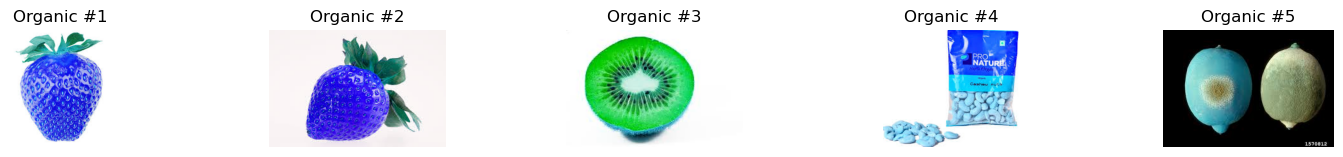

In [11]:
# Show first 5 Organic images
show_images_by_label(train_data_df, "O", 5)

### Recyclable waste

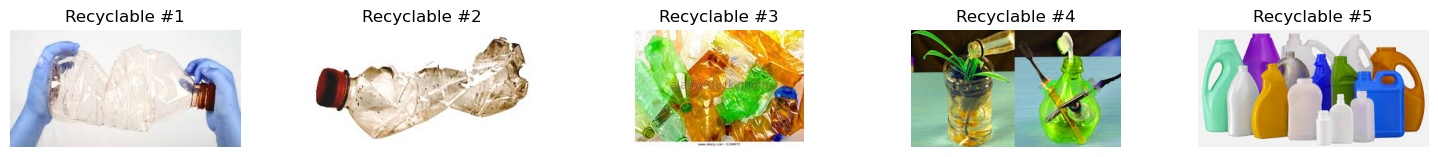

In [12]:
# Show first 5 Recyclable images
show_images_by_label(train_data_df, "R", 5)

## Data Augmentation
The reason for image transformations is because waste images can vary in:
- Lighting
- Angle
- Background clutter
- Object position

NB: These augmentations help your CNN generalize better and avoid overfitting to specific image setups.

In [13]:
# Rescale pixel values and add augmentation
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # Randomly rotate images up to 20 degrees
    width_shift_range=0.1, # Randomly shift images horizontally up to 10% of the width
    height_shift_range=0.1, # Randomly shift images vertically up to 10% of the height
    horizontal_flip=True, # Randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
    shear_range=0.10, # crops part of the image
    zoom_range=0.10, # #zooms the image by 10%
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Link train_val_datagen to the file path directory,
# Then create train_generator, val_generator
train_generator = train_val_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary', # Automatically encode labels as 0 and 1
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary', # Automatically encode labels as 0 and 1
    subset='validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [15]:
# Link test_datagen to the file path directory,
# Then create test_generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary', # Automatically encode labels as 0 and 1
    shuffle=False # Keep the order of the labels
)

Found 2513 images belonging to 2 classes.


## Image Classification with a CNN Model

In [16]:
# Build the CNN model
model = Sequential()
model.add(Input(shape=(150, 150, 3)))

# Number of filters increases further deep into the network
# Add the first Convolutional layer, with 32 filters
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#  Add a second convolutional layer, with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#  Add a third convolutional layer, with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# The Flatten() layer takes 3D tensor (height, width, channels) and reshapes it into a 1D array
# Fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for the 2 classes
model.add(Dense(1, activation='sigmoid')) # Binary classification

# Print a summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile with Adam optimizer
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Train the CNN model

In [18]:
# Implement Early Stop and Model Check point
callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min'),
             ModelCheckpoint('../models/waste_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')]


In [19]:
# Train the Model
model_history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

Epoch 1/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 732s 1s/step - accuracy: 0.7603 - loss: 0.5125 - val_accuracy: 0.8063 - val_loss: 0.4162
Epoch 2/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 450s 795ms/step - accuracy: 0.8321 - loss: 0.4094 - val_accuracy: 0.8351 - val_loss: 0.3853
Epoch 3/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 451s 799ms/step - accuracy: 0.8415 - loss: 0.3790 - val_accuracy: 0.8021 - val_loss: 0.4124
Epoch 4/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 476s 842ms/step - accuracy: 0.8496 - loss: 0.3752 - val_accuracy: 0.8375 - val_loss: 0.3746
Epoch 5/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 459s 813ms/step - accuracy: 0.8590 - loss: 0.3541 - val_accuracy: 0.8424 - val_loss: 0.3657
Epoch 6/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 467s 827ms/step - accuracy: 0.8589 - loss: 0.3503 - val_accuracy: 0.8167 - val_loss: 0.4040
Epoch 7/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 483s 854ms/step - accuracy: 0.8636 - loss: 0.3420 - val_accuracy: 0.7797 - val_loss: 0.4828
Epoch 8/20
565/565 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - accuracy: 0.8618 - loss:

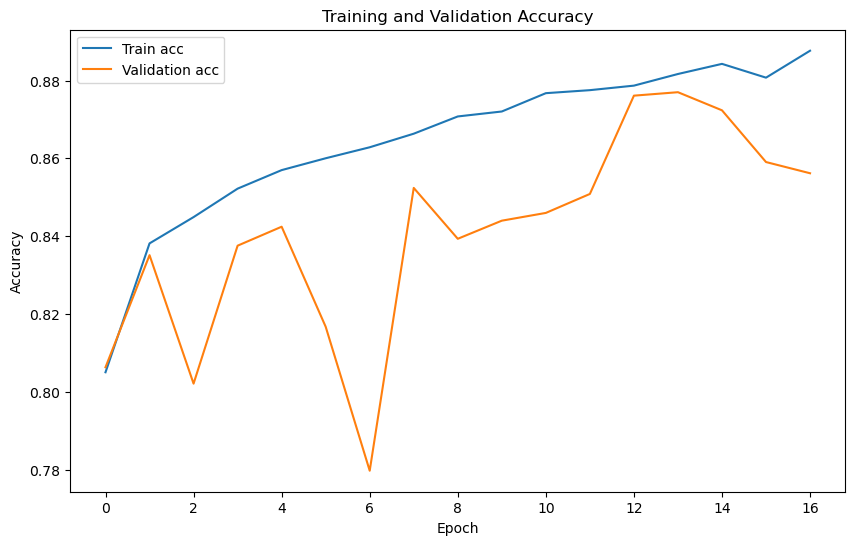

In [20]:
# Plots training and validation accuracy curves
plt.figure(figsize=[10,6])
plt.plot(model_history.history["accuracy"], label = "Train acc")
plt.plot(model_history.history["val_accuracy"], label = "Validation acc")

# Add title and labels
plt.title(f"Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Save plot to file
plt.savefig("../outputs/model_history_accuracy.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

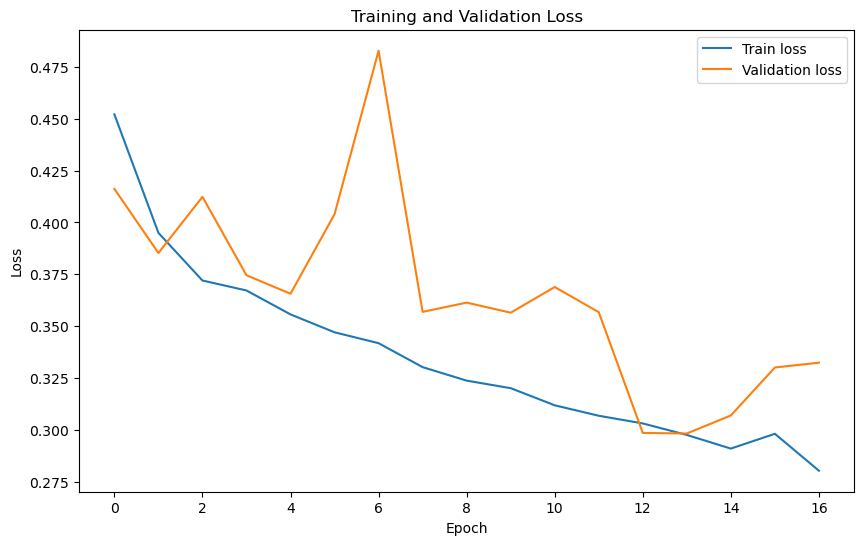

In [21]:
# Plots training and validation loss curves
plt.figure(figsize=[10,6])
plt.plot(model_history.history["loss"], label = "Train loss")
plt.plot(model_history.history["val_loss"], label = "Validation loss")

# Add title and labels
plt.title(f"Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Save plot to file
plt.savefig("../outputs/model_history_loss.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [22]:
# Load the best saved model
model = load_model('../models/waste_best_model.keras')

# Display the model architecture again to verify loading
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,485,445 (55.26 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,656,964 (36.84 MB)

In [23]:
# Test Loss and Accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 502ms/step - accuracy: 0.9231 - loss: 0.2199
Test Loss: 0.3096
Test Accuracy: 0.8934


In [24]:
# View how labels are mapped
print(train_generator.class_indices)

{'O': 0, 'R': 1}


In [25]:
# Get predictions (probabilities)
pred_probs = model.predict(test_generator)

# Convert probabilities to class labels (0 or 1)
pred_labels = (pred_probs > 0.5).astype("int").flatten()

# Get actual class labels from test generator
true_labels = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Actual Labels:", [class_labels[i] for i in true_labels[:10]])
print("Predicted Labels:", [class_labels[i] for i in pred_labels[:10]])

79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step
Actual Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Classification Report and Confusion Matrix
- Analyse model performance by its classification report and how it classifies labels

In [26]:
# Print classification report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

           O       0.88      0.93      0.91      1401
           R       0.91      0.84      0.87      1112

    accuracy                           0.89      2513
   macro avg       0.90      0.89      0.89      2513
weighted avg       0.89      0.89      0.89      2513



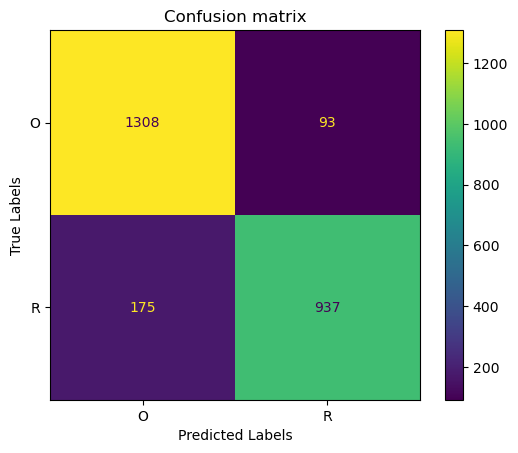

In [27]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot()

# Add title and labels
plt.title("Confusion matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Save plot to file
plt.savefig("../outputs/confusion_matrix.png", dpi=300, bbox_inches='tight')

# Show plot
plt.show()

## Visualisation of test images versus predictions
- Randomly select some test images for comparison with predicted labels

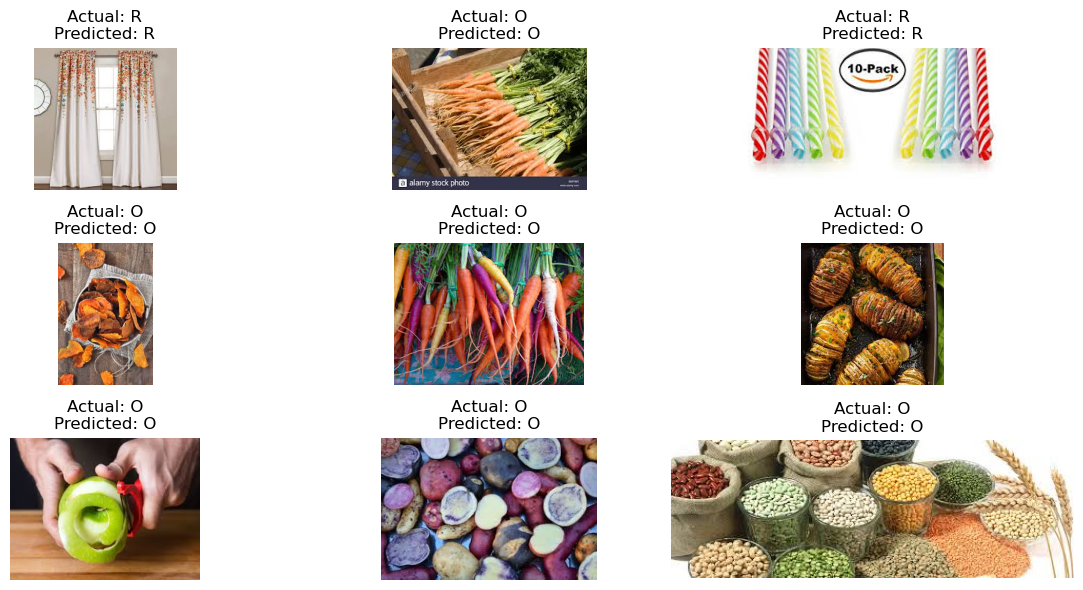

In [28]:
# Gain access to test_generator to fetch file names for test images
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 9, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[pred_labels[idx]]
    actual_label = class_labels[true_labels[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=12)

plt.tight_layout()

# Save plot to file
plt.savefig("../outputs/test_vs_prediction.png", dpi=300, bbox_inches='tight')

# Show Plot
plt.show()